In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
import seaborn as sns

In [5]:
sns.set_context('poster', font_scale=1.25)

In [6]:
import findspark as fs

In [7]:
fs.init()

In [8]:
import pyspark as ps

In [9]:
import multiprocessing as mp

In [10]:
mp.cpu_count()

12

In [11]:
config = ps.SparkConf()
config = config.setMaster('local[' + str(2*mp.cpu_count()) + ']')
config = config.setAppName('ipython_testing')

In [12]:
sc = ps.SparkContext(conf=config)

In [13]:
import P2

In [14]:
num_pixels = 2000

In [15]:
num_pixels = 2000
rows = sc.range(num_pixels, numSlices=10)
cols = sc.range(num_pixels, numSlices=10)

In [16]:
indices = rows.cartesian(cols)

In [17]:
def mandelbrot_wrapper(row, col):
    x = col/(num_pixels/4.) - 2.
    y = row/(num_pixels/4.) - 2.
    
    return ((row, col), P2.mandelbrot(x, y))


In [18]:
mandelbrot_rdd = indices.map(lambda a: mandelbrot_wrapper(*a))

We now need to turn this into a key-value pair...

In [19]:
mandelbrot_result = mandelbrot_rdd.collect()

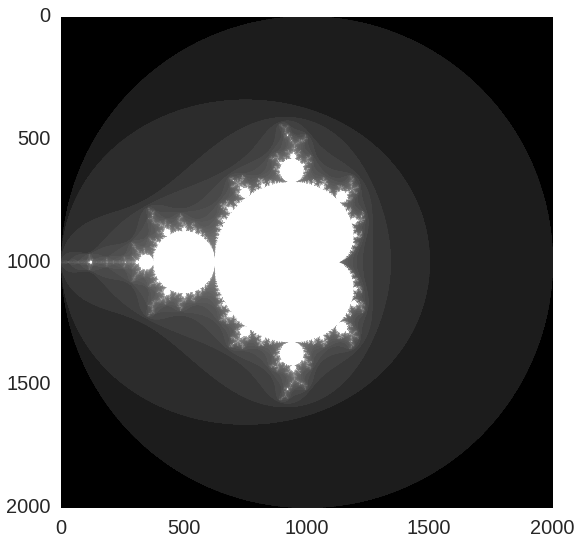

In [20]:
plt.grid(False)
P2.draw_image(data=mandelbrot_result)

Beautiful. We have liftoff! Let's try to make that histogram now. I have now initialized the # of cores correctly, thankfully. How can we get a list of the work done on each partition...?

In [23]:
summed_rdd = P2.sum_values_for_partitions(mandelbrot_rdd)

In [24]:
summed_result = summed_rdd.collect()

In [27]:
len(summed_result)

100

Well, at least that has the correct shape...ok I get it. It sums the number of iterations taken to make this shape in each parition. So, the plot we need is

(array([ 82.,   4.,   0.,   0.,   2.,   0.,   0.,   2.,   0.,   0.,   0.,
          1.,   1.,   0.,   0.,   2.,   2.,   0.,   2.,   2.]),
 array([        0.,   1022000.,   2044000.,   3066000.,   4088000.,
          5110000.,   6132000.,   7154000.,   8176000.,   9198000.,
         10220000.,  11242000.,  12264000.,  13286000.,  14308000.,
         15330000.,  16352000.,  17374000.,  18396000.,  19418000.,
         20440000.]),
 <a list of 20 Patch objects>)

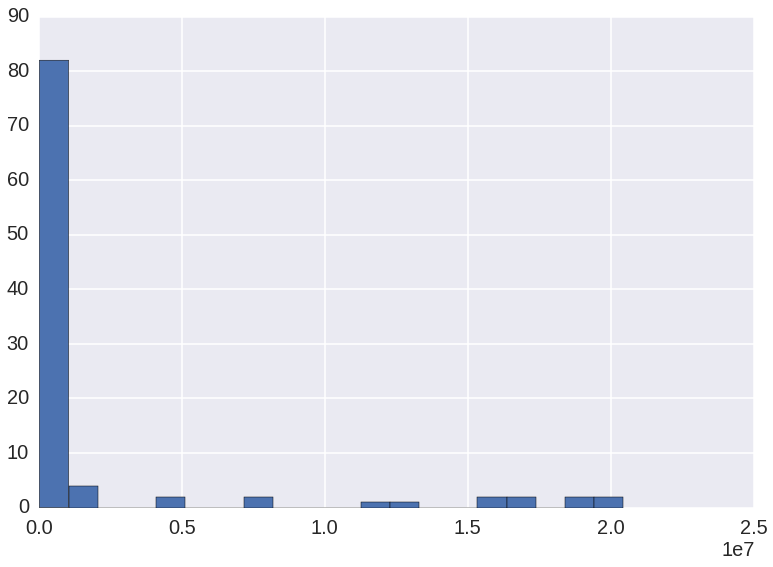

In [29]:
plt.hist(summed_result, bins=20)

We probably need a log scale...

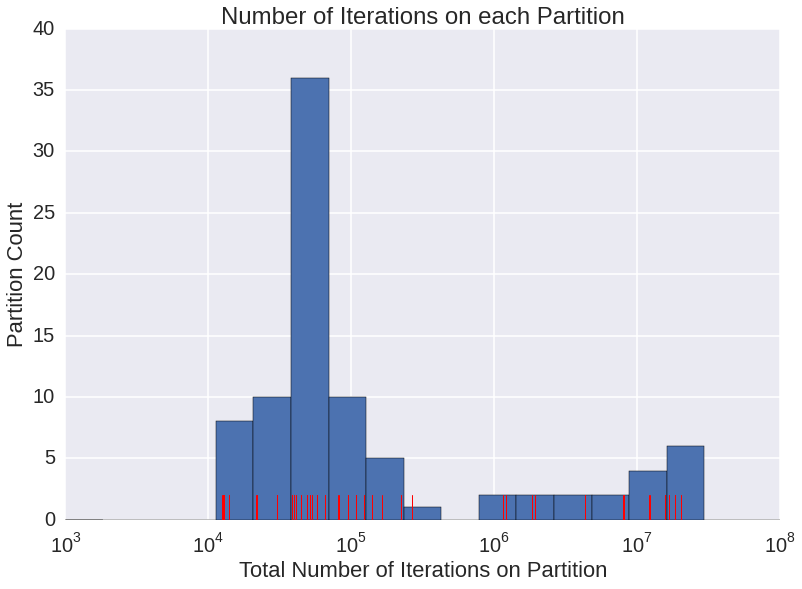

In [57]:
plt.hist(summed_result, bins=np.logspace(3, 8, 20))
sns.rugplot(summed_result, color='red')
plt.gca().set_xscale('log')
plt.xlabel('Total Number of Iterations on Partition')
plt.ylabel('Partition Count')
plt.title('Number of Iterations on each Partition')

Ok. This is instructive. The jobs run over several orders of magnitude. The rugplot is awesome because it gives you a real feeling of how many events there are distributed over space.